In [160]:
import numpy as np
import random
from itertools import product                   

In [281]:
def binomial(x):
    if isinstance(x, (list, tuple)):
        x = np.array(x, dtype=np.float32)
    return np.stack(
        [
            x[0]**2,
            x[0],
            x[0]*x[1],
            x[1],
            x[1]**2,
            np.ones(shape=x[0].shape)
        ], 0)

def new_layer(conn, layers, weights, assumptions):
    if conn:
        new_node = max(list(conn.keys()))+1
    else:
        new_node = max(layers[-1])+1
    if len(layers)>1:
        pool = layers[-1]+layers[0]
    else:
        pool = layers[0]
    new_layer = {n+new_node:x for n,x in enumerate(product(pool, repeat=2))}
    
    layers.append(list(new_layer.keys()))
    conn.update(new_layer)
    
    for n in layers[-1]:
        weights[n] = np.array(np.random.normal(0, 1, 6)*assumptions, dtype=np.float32)

def prune(conn, layers, weights, root):
    new_layers = [[] for _ in layers]
    new_layers[-1].append(root)
    new_connections = {root: conn[root]}
    new_weights = {root: weights[root]}
    
    child = list(new_connections[root])
    
    for nl in range(len(layers)-2, -1, -1):
        for node in layers[nl]:
            if node in child:
                new_layers[nl].append(node)
                if node in conn:
                    new_connections[node] = conn[node]
                    new_weights[node] = weights[node]
                child.remove(node)
        for node in new_layers[nl]:
            if node in conn:
                child += list(conn[node])
        child = list(set(child))
    
    return new_connections, new_layers, new_weights
    
    conn.update(new_layer)

def calculate(conn, layers, weights, values):
    """
    inputs: {input: [value list]} dict
    """
    values = {k: np.array(v, dtype=np.float32) for k, v in values.items()}
    for nl, layer in enumerate(layers[1:]):
        for nn, node in enumerate(layer):
            left, right = conn[node]
            values[node] = np.einsum("ij,i->j",binomial([values[left], values[right]]),weights[node])
    return values


def regress(conn, layers, weights, inputs, true_values, keep=3, conv_thres=1, iter_thres=1000, assumptions=None):
    if assumptions == None:
        assumptions = np.array([1,1,1,1,1,1])
    error_keep_best = np.zeros((keep))
    error_prev = np.ones((keep), dtype=np.float32)*conv_thres*10
    iteration = 0
    if isinstance(true_values, (list, tuple)):
        true_values = np.array(true_values, dtype=np.float32)
    n_points = true_values.shape[0]
    while (np.abs(error_keep_best - error_prev) >= conv_thres).all() and iteration < iter_thres:
        values = calculate(conn, layers, weights, inputs)
        out_layer_values = np.array([values[n] for n in layers[-1]], dtype=np.float32)
        iteration += 1
        error_prev = error_keep_best
        error = out_layer_values - np.einsum("ij,j->ij", np.ones_like(out_layer_values), true_values)
        speed = 1/2+(iter_thres-iteration)/(2*iter_thres)
        for nn, node in enumerate(layers[-1]):
            left, right = conn[node]
            dw = np.einsum("ij,j->i",binomial([values[left], values[right]]), error[nn])
            weights[node] -= dw/np.linalg.norm(dw)*speed*assumptions
        
        best_nodes, error_keep_best = list(zip(*sorted(zip(layers[-1], error), key=lambda x: np.sum(x[1]**2))[:keep]))
        error_keep_best = np.sum(np.array(error_keep_best)**2, 1)
    return best_nodes, error_keep_best

def grow(inputs, 
         true_values,
         depth_thres = 10,
         regress_conv = 1,
         regress_iter = 1000,
         goal = 1,
         keep = 3,
         return_everything = False,
         assumptions=None):
    
    if assumptions == None:
        assumptions = np.array([1,1,1,1,1,1])
    model_inputs = tuple(inputs.keys())
    layers = [model_inputs]
    weights = {}
    connections = {}
    errors = np.array([goal])
    iteration = 0
    
    pconnections, players, pweights, perrors = connections.copy(), layers.copy(), weights.copy(), errors.copy()
    
    while (np.abs(errors) >= goal).all() and iteration < depth_thres:
        if np.sum(errors-perrors)>0 and iteration > 1:
            connections, layers, weights, errors = pconnections, players, pweights, perrors
            break
    
        pconnections, players, pweights, perrors = connections.copy(), layers.copy(), weights.copy(), errors.copy()
        iteration += 1
        
        new_layer(connections, layers, weights, assumptions)

        layers[-1], errors = regress(
            conn=connections, 
            layers=layers, 
            weights=weights, 
            inputs=inputs, 
            true_values=true_values, 
            keep=keep, 
            conv_thres=regress_conv, 
            iter_thres=regress_iter,
            assumptions=assumptions
        )
    if not return_everything:
        root = layers[-1][0]
        best_tree = prune(connections, layers, weights, root)
        return best_tree, root, errors[0]
    else:
        return connections, layers, weights, errors

({110: (6, 5)}, [[5, 6], [110]], {110: array([-0.28622308, -0.00585802, -0.00755781, -0.00545821, -0.23418768,
       -0.54433274], dtype=float32)})
1.750106893574225


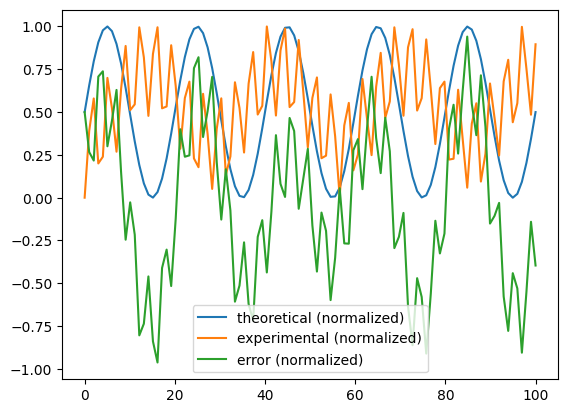

In [292]:
n_p = 100
inps = list(range(0,1))

t_start = 0 #ms
t_end = 100 #ms
t = np.linspace(t_start,t_end, n_p) #ms

noise = np.sin(t*2*np.pi/(1000/50))*0.1
siga = np.random.randint(2, size=n_p) + noise
sigb = np.random.randint(2, size=n_p) + noise

t_p = {0: siga, 1: sigb}
for i in range(2,15):
    t_p[i] = np.cos((i-2)*t)
t_y = noise

ass = [1,1,1,1,1,1]
tree, root, error = grow(t_p, t_y, goal=0.01, depth_thres=3, keep=5, regress_conv=0.01, regress_iter=2000, assumptions=ass)
print(tree)
c_p = t_p
c_y = t_y

theor_norm = (c_y-np.min(c_y))/(np.max(c_y)-np.min(c_y))
experimental = calculate(*tree, c_p)[root]
exp_norm = (experimental-np.min(experimental))/(np.max(experimental)-np.min(experimental))
print(error)

fig, ax = plt.subplots()
th, = ax.plot(t, theor_norm, label="theoretical (normalized)")
ex, = ax.plot(t, exp_norm, label="experimental (normalized)")
er, = ax.plot(t, theor_norm-exp_norm, label="error (normalized)")
ax.legend(handles=[th,ex,er])

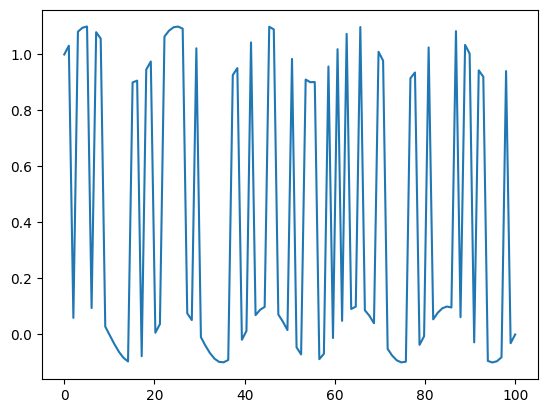

In [289]:
plt.plot(t, siga)

1.3323638


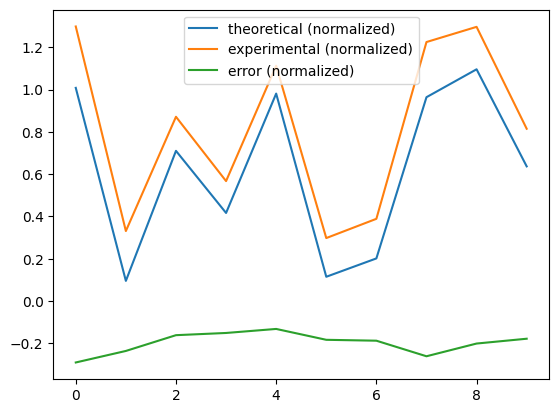

In [137]:
n_p = 10
inps = (0,1,2)

t_f = lambda x: x[1]**6+x[0]**2*0.5+3*x[2]
t_p = {i: [random.random() for _ in range(n_p)] for i in inps}
t_y = list(map(t_f,zip(*t_p.values())))


bino = lambda x,w: np.einsum("i->", w*binomial(x))
ass = np.array([1,1,1,1,1,1], dtype=np.float32)
tree, root, error = grow(t_p, t_y, goal=0.01)

x = list(range(n_p))
c_p = {i: [random.random() for _ in range(n_p)] for i in inps}
c_y = np.array(list(map(t_f,zip(*c_p.values()))))

theor_norm = c_y/(np.max(c_y)-np.min(c_y))
experimental = calculate(*tree, c_p)[root]
exp_norm = experimental/(np.max(experimental)-np.min(experimental))
print(error)

fig, ax = plt.subplots()
th, = ax.plot(x, theor_norm, label="theoretical (normalized)")
ex, = ax.plot(x, exp_norm, label="experimental (normalized)")
er, = ax.plot(x, theor_norm-exp_norm, label="error (normalized)")
ax.legend(handles=[th,ex,er])

582.1413


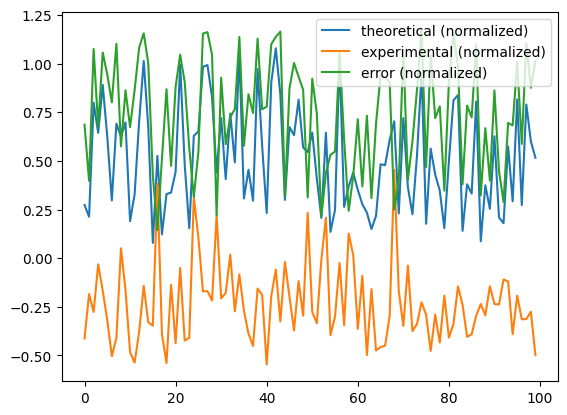

In [199]:
n_p = 100
inps = (0,1,2)

t_f = lambda x: 0.7*x[0]**3+0.3*x[1]+0.6*x[2]**2
t_p = {i: [random.random()*5 for _ in range(n_p)] for i in inps}
t_y = list(map(t_f,zip(*t_p.values())))


bino = lambda x,w: np.einsum("i->", w*binomial(x))
ass = np.array([1,1,1,1,1,1], dtype=np.float32)
tree, root, error = grow(t_p, t_y, goal=0.01)

x = list(range(n_p))
c_p = {i: [random.random() for _ in range(n_p)] for i in inps}
c_y = np.array(list(map(t_f,zip(*c_p.values()))))

theor_norm = c_y/(np.max(c_y)-np.min(c_y))
experimental = calculate(*tree, c_p)[root]
exp_norm = experimental/(np.max(experimental)-np.min(experimental))
print(error)

fig, ax = plt.subplots()
th, = ax.plot(x, theor_norm, label="theoretical (normalized)")
ex, = ax.plot(x, exp_norm, label="experimental (normalized)")
er, = ax.plot(x, theor_norm-exp_norm, label="error (normalized)")
ax.legend(handles=[th,ex,er])

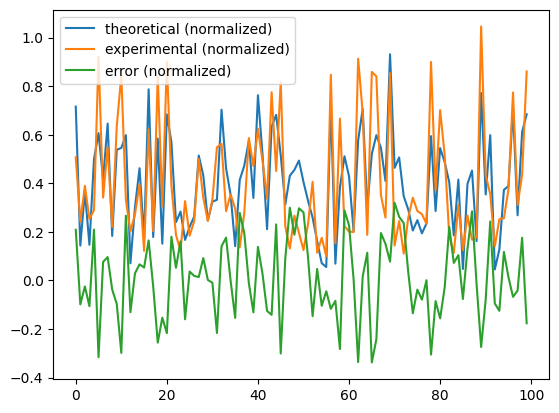

In [195]:
fig, ax = plt.subplots()
th, = ax.plot(x[:100], theor_norm[:100], label="theoretical (normalized)")
ex, = ax.plot(x[:100], exp_norm[:100], label="experimental (normalized)")
er, = ax.plot(x[:100], theor_norm[:100]-exp_norm[:100], label="error (normalized)")
ax.legend(handles=[th,ex,er])

7322.329


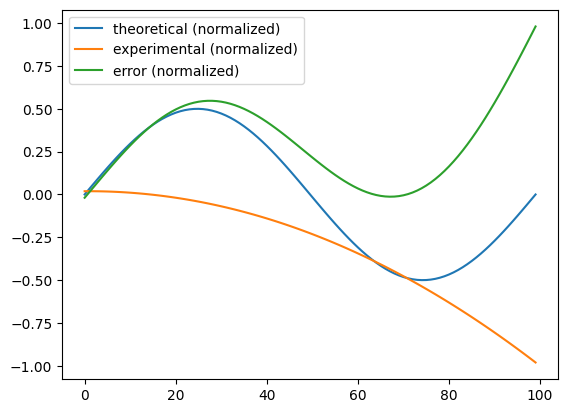

In [157]:
n_p = 100
inps = (0,)

t_f = lambda x: np.sin(x[0])
t_p = {i: [random.random()*2*np.pi for _ in range(n_p)] for i in inps}
t_y = list(map(t_f,zip(*t_p.values())))


bino = lambda x,w: np.einsum("i->", w*binomial(x))
ass = np.array([1,1,1,1,1,1], dtype=np.float32)
tree, root, error = grow(t_p, t_y, goal=0.01)

x = list(range(n_p))
c_p = {i: np.linspace(0, 2*np.pi, n_p) for i in inps}
c_y = np.array(list(map(t_f,zip(*c_p.values()))))

theor_norm = c_y/(np.max(c_y)-np.min(c_y))
experimental = calculate(*tree, c_p)[root]
exp_norm = experimental/(np.max(experimental)-np.min(experimental))
print(error)

fig, ax = plt.subplots()
th, = ax.plot(x, theor_norm, label="theoretical (normalized)")
ex, = ax.plot(x, exp_norm, label="experimental (normalized)")
er, = ax.plot(x, theor_norm-exp_norm, label="error (normalized)")
ax.legend(handles=[th,ex,er])

142.11877


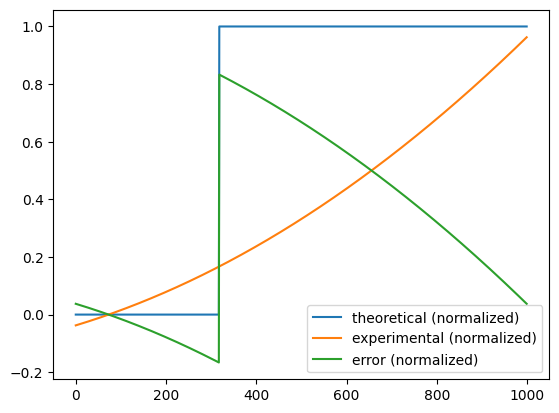

In [159]:
n_p = 1000
inps = (0,)

t_f = lambda x: float(x[0]>1)
t_p = {i: [random.random()*np.pi for _ in range(n_p)] for i in inps}
t_y = list(map(t_f,zip(*t_p.values())))


bino = lambda x,w: np.einsum("i->", w*binomial(x))
ass = np.array([1,1,1,1,1,1], dtype=np.float32)
tree, root, error = grow(t_p, t_y, goal=0.01)

x = list(range(n_p))
c_p = {i: np.linspace(0, np.pi, n_p) for i in inps}
c_y = np.array(list(map(t_f,zip(*c_p.values()))))

theor_norm = c_y/(np.max(c_y)-np.min(c_y))
experimental = calculate(*tree, c_p)[root]
exp_norm = experimental/(np.max(experimental)-np.min(experimental))
print(error)

fig, ax = plt.subplots()
th, = ax.plot(x, theor_norm, label="theoretical (normalized)")
ex, = ax.plot(x, exp_norm, label="experimental (normalized)")
er, = ax.plot(x, theor_norm-exp_norm, label="error (normalized)")
ax.legend(handles=[th,ex,er])

3.6011512


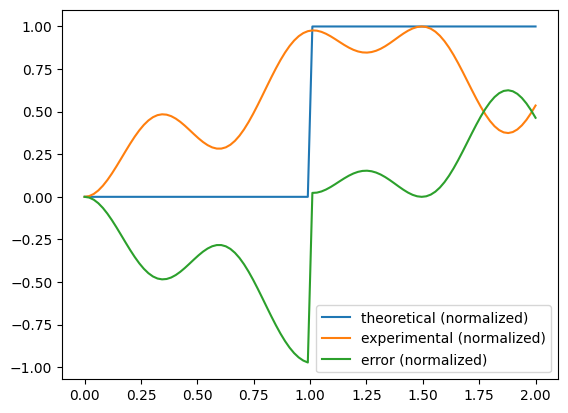

In [191]:
n_p = 100
inps = list(range(-10,11))

t = np.linspace(0,2, n_p)
t_f = lambda x: float(x>1)
t_p = {i: [np.cos(time*i) for time in t] for i in inps}
t_y = list(map(t_f,t))


bino = lambda x,w: np.einsum("i->", w*binomial(x))
ass = np.array([1,1,1,1,1,1], dtype=np.float32)
tree, root, error = grow(t_p, t_y, goal=0.01)

c_p = t_p
c_y = t_y

theor_norm = (c_y-np.min(c_y))/(np.max(c_y)-np.min(c_y))
experimental = calculate(*tree, c_p)[root]
exp_norm = (experimental-np.min(experimental))/(np.max(experimental)-np.min(experimental))
print(error)

fig, ax = plt.subplots()
th, = ax.plot(t, theor_norm, label="theoretical (normalized)")
ex, = ax.plot(t, exp_norm, label="experimental (normalized)")
er, = ax.plot(t, theor_norm-exp_norm, label="error (normalized)")
ax.legend(handles=[th,ex,er])